# Validation of NISAR Requirement L2-SCI-738:  </br>Ice sheet and glacier velocity measurement - Ice sheet velocity sampling
---

This notebook documents and executes the steps need to validate the NISAR frequent sampling of ice flow velocity requirement (L2-SCI-738), which is specified as:

**The NISAR Project shall measure time-varying horizontal velocities of ice-sheets at near-weekly sampling intervals in areas of potential rapid (e.g., outlet glaciers) or seasonal change to an accuracy better than 3% of the horizontal velocitiy magnitude plus 10 m/yr (1-sigma) at 500-m resolution (> 80% coverage).**

As described below this process amounts to comparing L3 velocity products generated as described in the NISAR ATBD with points of known velocity and elevations. Specifically, the Cal/Val points will consist of:
* On-ice GPS measurements of ice flow speed ($v_x$,$v_y$) and elevation ($z$).

Errors are evaluated as the means ($\mu_x,\mu_y$), standard deviations ($\sigma_x,\sigma_y$), and root-mean-squares (rms) of the diferences between the SAR-measured velocity ($v_x,v_y$) and the nominally GPS-measured cal/val points ($u_x,u_y$). Explicitly, these calculations are:

$\bar{\mu}_x = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (v_x-u_x)$, &nbsp;&nbsp;&nbsp;       $\bar{\mu}_y = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (v_x-u_x)$ </br>
$\hat{\sigma}_x^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((v_x-u_x)-\bar{\mu_x})^2$, &nbsp;&nbsp;&nbsp;    $\hat{\sigma}_y^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((v_y-u_y)-\bar{\mu_y})^2$ </br>
$rms_x = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} ((v_x-u_x))^2}$, &nbsp;&nbsp;&nbsp; 
$rms_y = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} ((v_y-u_y))^2}$

The requirement poses the error in terms of a fixed value (1 m/yr) and percentage error (3%). To pass the requirement for a set of points, the mean error of the results should be less than the mean error thresholds for the point. Conceptually, if not rigorously, these two error sources can be thought of as the precision component (1 m/yr) and potential bias (3%). Consistent biases at a point through time may be caused by processing artifacts such as a slope error in the DEM used to apply the surface parallel flow correction. Specifically, the error should be less than:

${thresh}_x = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (1)^2 + (0.03u_x)^2 }$ m/yr, &nbsp;&nbsp;&nbsp;    ${thresh}_y = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (1)^2 + (0.03u_y)^2 }$ m/yr

Since biases are possible, the requirement is met where the $rms$ for a component is less the than corresponding $thresh$.

The rest of this notebook is designed to access remotely stored L3 velocity maps and evaluate them using a set of GPS cal/val points. This notebook evaluates the differences between the GPS cal/val points and velocity maps produced by the Greenland Mapping Project sponsored by the NASA MEaSUREs program. The rms values of these differences are used to determine whether the above requirement is met. The products are gridded at 200 rather than 500 m.

**A present this notebook is only a prototype and works using prodcuts created using data products derived using SAR data from sensors other than NISAR, albeit with the same algorithms and workflow. To emulate the points that will be collected by the project, this notebook uses a recently collected set of GPS points (Abbas Khan, personal communication to Eric Rignot).**

## Python Setup

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
from urllib import request
import grimpfunc as grimp
import matplotlib.pyplot as plt
import panel
import numpy as np
from datetime import datetime
import pandas as pd
from dask.diagnostics import ProgressBar
ProgressBar().register()
panel.extension()

## Login for Remote Access

For remote access to data at NSIDC, run these cells to login with a valid NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GRiMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details and security concerns). Descriptions of these data products are avaiable at [NSIDC](https://nsidc.org/data/measures/gimp). The algorithms used to produce these products are described in the written [ATBD](https://github.com/fastice/nisarCryoCalValNotebooks/blob/main/ATBD-Documents/ATBD_IceSheetVelocity-Version2.pdf) and the [NISAR Users handbook](https://nisar.jpl.nasa.gov/rails/active_storage/disk/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9JYTJWNVNTSXBZV0V4T1RRNE5HVXRaV1V6WVMwMFltTXpMV0ppWkdRdE16VXpNekZoWldNeFkyWTFCam9HUlZRNkVHUnBjM0J2YzJsMGFXOXVTU0pYYVc1c2FXNWxPeUJtYVd4bGJtRnRaVDBpVGtsVFFWSmZSa2xPUVV4Zk9TMDJMVEU1TG5Ca1ppSTdJR1pwYkdWdVlXMWxLajFWVkVZdE9DY25Ua2xUUVZKZlJrbE9RVXhmT1MwMkxURTVMbkJrWmdZN0JsUTZFV052Ym5SbGJuUmZkSGx3WlVraUZHRndjR3hwWTJGMGFXOXVMM0JrWmdZN0JsUT0iLCJleHAiOiIyMDIyLTAxLTI3VDIxOjA2OjEzLjk0OFoiLCJwdXIiOiJibG9iX2tleSJ9fQ==--46c90ad132272eb5855fecb3070780e162777a62/NISAR_FINAL_9-6-19.pdf?content_type=application%2Fpdf&disposition=inline%3B+filename%3D%22NISAR_FINAL_9-6-19.pdf%22%3B+filename%2A%3DUTF-8%27%27NISAR_FINAL_9-6-19.pdf).

In [2]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)

In [3]:
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Cal/Val Points (cvPoints)

The **cvPoints** class is used to read in, filter (by speed), and interpolate cal/val points. 

At present, cal/val points are stored in a flat ascii file with rows given by:

*lat lon elevation vx vy vz 
...*
The following examples demontrate selection of point locations by speed.

In [4]:
ptFiles = ['../GPSpoints/NEGIS1_velocity.corrected.txt', '../GPSpoints/NEGIS2_velocity.corrected.txt', '../GPSpoints/NEGIS3_velocity.corrected.txt'] 
myCVPts = nisar.cvPoints()
myCVPts.readCVs(ptFiles)

The bounding box of the cal/val points with a 20-km pad can be found as:

In [5]:
bbox = myCVPts.boundingBox(pad=20e3, units='m') # Get the bounding box for the cal/val points with a 10km pad.

This box is used below to limit the extent of the remote velocity maps for faster remote access and display.

## Select Data

There is good GPS coverage at all 3 points from mid April through August 2017 so this step pulls the images for this period. Once NISAR is launched, the NISAR products will be produced from the NISAR Cal/Val archive.

In [6]:
myUrls = grimp.cmrUrls(mode='nisar',)  # Subsetter mode is required for subsetting.
myUrls.initialSearch(product='NSIDC-0766', firstDate='2017-05-04', lastDate='2017-06-15');  # Remove ; to gain access to search controls

Each component in the velocity maps is ~240MB, so downloading 6 maps with 2 components each can take a significant amount of time. To avoid this wait, the urls returned from the search and crop them to match the  bounding box for the cal/val points as shown below. Before reading setting up the velocity, the url names are modifed to insert a wildcard ('\*') for the velocity components and remote the '.tif' extension. This step may still take a minute or two to run.

In [7]:
myVelSeries = nisar.nisarVelSeries()
myVelSeries.readSeriesFromTiff(myUrls.getCogs(replace='vv', removeTiff=True), url=True)
myVelSeries.subSetVel(bbox)
myVelSeries.loadRemote()

[########################################] | 100% Completed | 6.49 ss


Display the subsetted data and the location of the GNSS points.

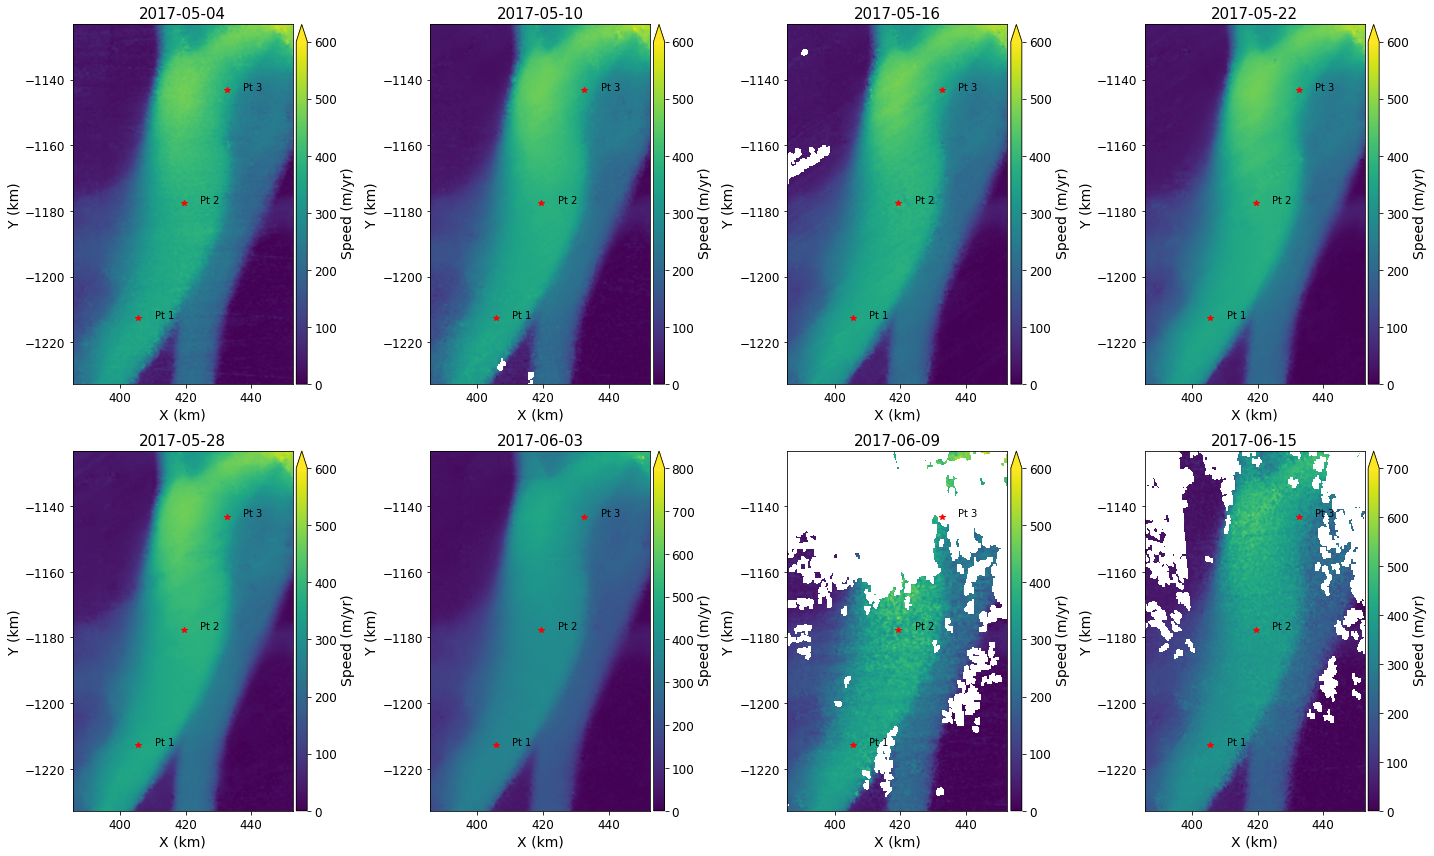

In [8]:
fig, axes = plt.subplots(2,4, figsize=(20,12))
dxAll, dyAll = [], []
for myDate, myDate1, myDate2, ax in zip(myVelSeries.time,myVelSeries.time1, myVelSeries.time2, axes.flatten()):
    myVelSeries.displayVelForDate(myDate, ax=ax, units='km')  # Display velocity data
    ax.plot(*myCVPts.xyVRange(0, 500, units='km'), 'r*')   # Plot points
    for xx, yy, i in zip(*myCVPts.xyVRange(0, 500, units='km'), range(1, 4)): # Label points
        ax.text(xx+5, yy, f'Pt {i}')
fig.tight_layout()

## Plot Differences

The differences between the estimated velocity ($v_x$ and $v_y$) and the cal/val GNSS measurements ($u_x$ and $u_y$) for each year are displayed as:

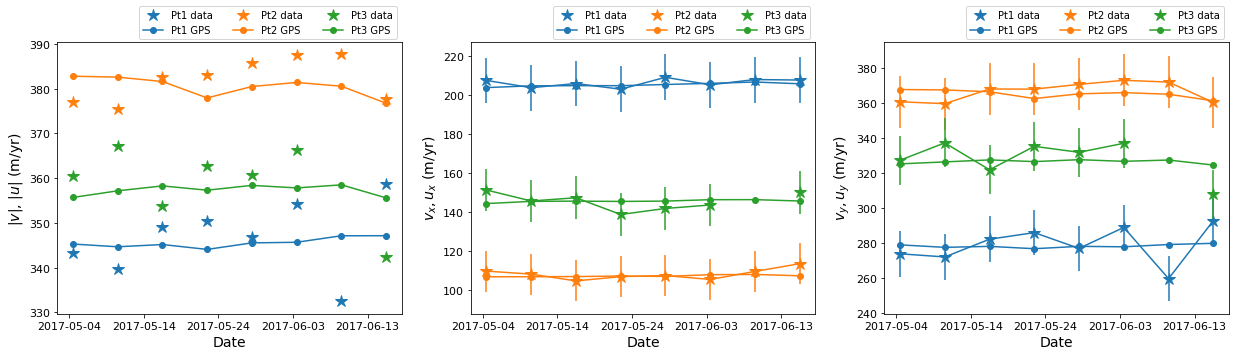

In [9]:
myCVPts.plotTimesSeriesData(myVelSeries, 0, 500, bands=['vv','vx', 'vy'], nTicks=5)

The error bars represent the 1-sigma NISAR requirements, $thresh_x$ and $thresh_y$. 

## Summary

The table below summarizes the statistics for the differences between the observed (SAR) and measured (GPS) velocities. Cases where the requiresments are not met are flagged with red text.

In [10]:
df, summary = myCVPts.timeSeriesStats(myVelSeries, 0, 500)
caption = f'Of {summary["nPts"] * 2} components derived from {summary["nPts"]} points, {summary["nPassed"]} meet requirements.<br>'
coverageMet = ['does not meet' , 'meets' ][int(summary["percentCoverage"] > 80.)]
caption += f'The coverage of {summary["percentCoverage"]:.0f}% {coverageMet} the 80% requirement'
df.style.pipe(myCVPts.statsStyle, **{'caption': caption})